In [287]:

from experiment_information import *
from data import *
from helpers import *
from _version import __version__
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import logging
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [288]:

from _version import __version__
df_experiments = None
df_state_evolution = None
df_erm = None
logger = logging.getLogger()
with DatabaseHandler(logger,"experiments/experiments.db") as dbHandler:
    df_experiments = dbHandler.get_experiments()
    df_state_evolution = dbHandler.get_state_evolutions()
    df_state_evolution["calibrations"] = df_state_evolution["calibrations"].apply(lambda x: json.loads(x))
    df_erm = dbHandler.get_erms()
    df_erm["analytical_calibrations"] = df_erm["analytical_calibrations"].apply(lambda x: json.loads(x))
    df_erm["erm_calibrations"] = df_erm["erm_calibrations"].apply(lambda x: json.loads(x))
    # delete incomplete experiments (bad, deletes running experiments...)
    # dbHandler.delete_incomplete_experiments()

def explode_calibrations(df):
    a = df["calibrations"].apply(pd.Series)
    # drop the original calibrations column
    df = df.drop(columns=["calibrations"])
    # concat the original dataframe with the new dataframe containing the exploded calibrations column
    df = pd.concat([df,a],axis=1)
    # explode both calibrations and ps columns
    df = df.explode(["calibrations","ps"])
    # rename the exploded columns
    df = df.rename(columns={"calibrations":"calibration","ps":"p_calibration"})
    return df
df_state_evolution = explode_calibrations(df_state_evolution)
def explode_erm_calibrations(df):
    a = df["erm_calibrations"].apply(pd.Series)
    # drop the original calibrations column
    df = df.drop(columns=["erm_calibrations"])
    b = df["analytical_calibrations"].apply(pd.Series)
    # drop the original calibrations column
    df = df.drop(columns=["analytical_calibrations"])
    # drop the dp and ps columns from b
    b = b.drop(columns=["dp","ps"])
    # rename the columns of b
    b = b.rename(columns={"calibrations":"analytical_calibration"})
    # rename the columns of a
    a = a.rename(columns={"calibrations":"erm_calibration"})
    # concat the original dataframe with the new dataframe containing the exploded calibrations column
    df = pd.concat([df,a],axis=1)
    df = pd.concat([df,b],axis=1)
    # explode both calibrations and ps columns
    df = df.explode(["erm_calibration","analytical_calibration","ps"])
    # rename the exploded columns
    df = df.rename(columns={"ps":"p_calibration"})
    return df
df_erm = explode_erm_calibrations(df_erm)
print("Current code version, ", __version__)

Current code version,  63


In [289]:
# get the completed experiments with the current code version ordered by date
version_choice = __version__
# version_choice = "54"
df_experiments = df_experiments[(df_experiments["completed"]==True) & (df_experiments["code_version"]==version_choice)]
df_experiments = df_experiments.sort_values(by="date",ascending=False)
df_experiments.head(3)

,experiment_id,experiment_name,duration,code_version,date,state_evolution_repetitions,erm_repetitions,alphas,epsilons,lambdas,taus,ps,dp,d,experiment_type,completed,data_model_type,data_model_name,data_model_description
27,ffeb2219-7093-425e-9b5e-125f9d824439,Vanilla Strong Weak Trials,30.001267,63,2023-10-26 14:24:41,1,2,[3.4],"[0.0, 0.2]",[0.1],[0],[0.75],0.01,1000,SweepAtOptimalLambda,1,VanillaGaussian,VanillaGaussian,A Data-Model with Identity Gaussians for all t...
26,a5502ada-38bb-4053-9bbe-62665cf4a0b8,Vanilla Strong Weak Trials,83.252312,63,2023-10-26 14:16:38,1,2,[3.4],"[0.0, 0.2]",[0.1],[0],[0.75],0.01,1000,OptimalLambda,1,VanillaGaussian,VanillaGaussian,A Data-Model with Identity Gaussians for all t...
23,ef9c0cec-0365-42c3-a739-8474079011c8,Vanilla Strong Weak Trials,0.011508,63,2023-10-26 14:15:04,1,2,[3.4],"[0.0, 0.2]",[0.1],[0],[0.75],0.01,1000,OptimalLambda,1,VanillaGaussian,VanillaGaussian,A Data-Model with Identity Gaussians for all t...


In [290]:
df_state_evolution["estimation_error"] = 1 + df_state_evolution["q"] - 2 * df_state_evolution["m"]

In [291]:
# extract and print the top experiment_id
experiment_id = df_experiments.iloc[0]["experiment_id"]
print(experiment_id)

# extract and print the data model type and data_model name used
data_model_type = df_experiments.iloc[0]["data_model_type"]
# convert it to the enum
data_model_type = DataModelType[data_model_type]
data_model_name = df_experiments.iloc[0]["data_model_name"]
data_model_description = df_experiments.iloc[0]["data_model_description"]
print(data_model_type.name, data_model_name)
print(data_model_description)

ffeb2219-7093-425e-9b5e-125f9d824439
VanillaGaussian VanillaGaussian
A Data-Model with Identity Gaussians for all the covariances.


In [292]:
round_to = 1
def my_floor(a, precision=round_to):
    return np.round(a - 0.5 * 10**(-precision), precision)
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
# ceil the alpha values to 1 decimal
state_evolution["alpha"] = state_evolution["alpha"].apply(lambda x: my_floor(x,precision=round_to))
erm = df_erm[df_erm["experiment_id" ] == experiment_id]

gd = erm[erm["chosen_minimizer"] == "sklearn"]
# ceil the alpha values to 1 decimal
gd["alpha"] = gd["alpha"].apply(lambda x: my_floor(x,precision=round_to))


# set alpha, epsilon, tau, lam as index in gd and state_evolution
gd = gd.set_index(["alpha","epsilon","tau","lam","p_calibration"]) 
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam","p_calibration"])
# from state_evolution keep generalization_error, sigma, q, m, cosb
state_evolution = state_evolution[["generalization_error","sigma","q","Q_self","m","cosb","training_loss","estimation_error","sigma_hat","q_hat","m_hat","adversarial_generalization_error","training_error","A","N","A_hat","N_hat","calibration","test_loss"]]
# add a suffix _state_evolution to the columns
state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
# from gd keep generalization_error_erm	generalization_error_overlap Q	rho	m	cosb
gd = gd[["generalization_error_erm","generalization_error_overlap","Q","rho","m","cosb", "training_error","d", "training_loss","test_loss","adversarial_generalization_error_erm","adversarial_generalization_error_overlap","A","N","erm_calibration","analytical_calibration"]] 
# add a suffix _erm to the columns
gd.columns = [col+"_erm" for col in gd.columns]
# join the two dataframes (if a value is missing in one of the two dataframes, it is filled with NaN)
df = state_evolution.join(gd, how="outer")
# reorder the columns
df = df[['generalization_error_state_evolution', 'generalization_error_erm_erm', 'generalization_error_overlap_erm', 'sigma_state_evolution', 'q_state_evolution','Q_erm',"Q_self_state_evolution",'m_state_evolution','m_erm','cosb_state_evolution','cosb_erm', 'rho_erm',"training_loss_state_evolution","training_loss_erm","training_error_erm","d_erm","test_loss_erm","estimation_error_state_evolution","sigma_hat_state_evolution","q_hat_state_evolution","m_hat_state_evolution","adversarial_generalization_error_state_evolution","adversarial_generalization_error_overlap_erm","adversarial_generalization_error_erm_erm","training_error_state_evolution","A_erm","N_erm","A_state_evolution","N_state_evolution","A_hat_state_evolution","N_hat_state_evolution","erm_calibration_erm","analytical_calibration_erm","calibration_state_evolution","test_loss_state_evolution"]]
# average all quantities over the index and obtain also the standard deviation
df = df.groupby(level=[0,1,2,3,4]).agg([np.mean,np.std]) 
# display all columns
pd.set_option('display.max_columns', None)
# # display all rows
# pd.set_option('display.max_rows', None)
df

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_4944/3762798695.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["alpha"] = state_evolution["alpha"].apply(lambda x: my_floor(x,precision=round_to))
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_4944/3762798695.py:30: FutureWarning: The provided callable <function mean at 0x1084d4540> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby(level=[0,1,2,3,4]).agg([np.mean,np.std])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_4944/3762798695.py:30: FutureWarning: The provided callable <function std at 0x1084d4720>

generalization_error_state_evolution  \
                                                                         mean   
alpha epsilon tau lam      p_calibration                                        
3.4   0.0     0.0 0.007661 0.75                                      0.117399   
      0.2     0.0 0.005644 0.75                                      0.117588   

                                              generalization_error_erm_erm  \
                                          std                         mean   
alpha epsilon tau lam      p_calibration                                     
3.4   0.0     0.0 0.007661 0.75           0.0                      0.12070   
      0.2     0.0 0.005644 0.75           0.0                      0.11996   

                                                    \
                                               std   
alpha epsilon tau lam      p_calibration             
3.4   0.0     0.0 0.007661 0.75           0.000438   
      0.2     0.0 0.005644 0.75           0.001075   

                                         generalization_error_overlap_erm  \
                                                                     mean   
alpha epsilon tau lam      p_calibration                                    
3.4   0.0     0.0 0.007661 0.75                                  0.120996   
      0.2     0.0 0.005644 0.75                                  0.120104   

                                                   sigma_state_evolution       \
                                               std                  mean  std   
alpha epsilon tau lam      p_calibration                                        
3.4   0.0     0.0 0.007661 0.75           0.002264             16.721735  0.0   
      0.2     0.0 0.005644 0.75           0.001679              8.880585  0.0   

                                         q_state_evolution           Q_erm  \
                                                      mean  std       mean   
alpha epsilon tau lam      p_calibration                                     
3.4   0.0     0.0 0.007661 0.75                  40.060624  0.0  40.630458   
      0.2     0.0 0.005644 0.75                  59.426384  0.0  57.808689   

                                                   Q_self_state_evolution  \
                                               std                   mean   
alpha epsilon tau lam      p_calibration                                    
3.4   0.0     0.0 0.007661 0.75           0.845055              56.782359   
      0.2     0.0 0.005644 0.75           0.281244              68.306970   

                                              m_state_evolution       \
                                          std              mean  std   
alpha epsilon tau lam      p_calibration                               
3.4   0.0     0.0 0.007661 0.75           0.0          5.903723  0.0   
      0.2     0.0 0.005644 0.75           0.0          7.188808  0.0   

                                             m_erm            \
                                              mean       std   
alpha epsilon tau lam      p_calibration                       
3.4   0.0     0.0 0.007661 0.75           5.929084  0.065024   
      0.2     0.0 0.005644 0.75           7.010155  0.093202   

                                         cosb_state_evolution       cosb_erm  \
                                                         mean  std      mean   
alpha epsilon tau lam      p_calibration                                       
3.4   0.0     0.0 0.007661 0.75                      0.932754  0.0  0.928609   
      0.2     0.0 0.005644 0.75                      0.932540  0.0  0.929650   

                                                     rho_erm            \
                                               std      mean       std   
alpha epsilon tau lam      p_calibration                                 
3.4   0.0     0.0 0.007661 0.75           0.002639  1.003420  0.004566   
      0.2     0.0 0.00564

In [293]:
optimal_lambdas = load_csv_to_object_dictionary(OptimalLambdaResult(0,0,0,0,None,None),path="experiments/")
def extract_optimal_lambda(alpha, epsilon, tau, data_model_type, data_model_name):
    # extract or compute optimal lamba and plot it as a vertical line
    optimal_result = OptimalLambdaResult(alpha,epsilon,tau,1,data_model_type,data_model_name)
    if optimal_result.get_key() in optimal_lambdas:
        optimal_lambda = optimal_lambdas[optimal_result.get_key()]
        return optimal_lambda
    else:
        raise Exception("Optimal lambda not found for key " + str(optimal_result.get_key()) )
    

In [294]:
first_iteration = "tau"
second_iteration = "alpha" # "lam"
target = "lam"
sweep = "epsilon"
def create_plot(df, error_name, state_evolution_name, gd_name, log_x = False, log_y=False, fix_a_variable = None, variable_value = None, filename=None):
    df2 = df.reset_index()
    # Define a color palette to use for the different epsilon values
    palette = sns.color_palette(n_colors=len(df2[sweep].unique()))

    d = df2['d_erm']["mean"][0]

    for tau in df2[first_iteration].unique():

        iterate_over = df2[second_iteration].unique() if second_iteration is not None else [None]

        for lam in iterate_over:

            # Filter the dataframe for the current values of tau and lam
            if second_iteration is None:
                data = df2[(df2[first_iteration] == tau)]
            else:
                data = df2[(df2[first_iteration] == tau) & (df2[second_iteration] == lam)]

            if fix_a_variable is not None:
                data = data[data[fix_a_variable] == variable_value]
            
            for i, epsilon in enumerate(data[sweep].unique()):
                # Filter the dataframe for the current value of epsilon
                epsilon_subset = data[data[sweep] == epsilon]

                # Plot the state_evolution results as a line
                if state_evolution_name is not None:
                    if state_evolution_name in ["alpha","tau","lam","epsilon"]:
                        plt.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name)], label=f'{sweep}: {epsilon}', color=palette[i])
                    else:
                        plt.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep}: {epsilon}', color=palette[i])
                
                # Plot the gradient_descent results as points with error bars
                if gd_name is not None:
                    try:
                        plt.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[i], capsize=5)
                    except:
                        pass

                if error_name == "Generalization Error" and target == "lam":
                    optimal_lambda = extract_optimal_lambda(alpha=lam, epsilon=epsilon, tau=tau, data_model_type=data_model_type, data_model_name=data_model_name)
                    # plot the optimal lambda as a vertical line
                    plt.axvline(x=optimal_lambda, color=palette[i], linestyle='--')

            
            if log_x:
                plt.xscale('log')
            if log_y:
                plt.yscale('log')

            # Add labels and title
            plt.xlabel(target)
            plt.ylabel(error_name)
            if fix_a_variable is not None:
                if second_iteration is None:
                    plt.title(f'{error_name} - {first_iteration}: {tau}, d: {d} - {fix_a_variable}: {variable_value}')
                else:
                    plt.title(f'{error_name} - {first_iteration}: {tau}, {second_iteration}: {lam}, d: {d} - {fix_a_variable}: {variable_value}')
            else:
                if second_iteration is None:
                    plt.title(f'{error_name} - {first_iteration}: {tau}, d: {d}')
                else:
                    plt.title(f'{error_name} - {first_iteration}: {tau}, {second_iteration}: {lam}, d: {d}')
            # Add a legend
            plt.legend()

            # add a grid
            plt.grid()

            plt.tight_layout()

            if fix_a_variable is not None:
                name = f"{error_name}_tau_{tau}_lam_{lam}_d_{d}_{fix_a_variable}_{variable_value}_v_{__version__}"
            else:
                name = f"{error_name}_tau_{tau}_lam_{lam}_d_{d}_v_{__version__}"
            # Save the plot as svg
            if filename is not None:
                plt.savefig(f"Assets/{filename}_{name}.pdf", bbox_inches='tight')

            # Show the plot
            plt.show()

In [295]:
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=1.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=2.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=5.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=15.0)

In [296]:
# create_plot(df,"Optimal Lambda", "lam", None,filename="Optimal_lambda")

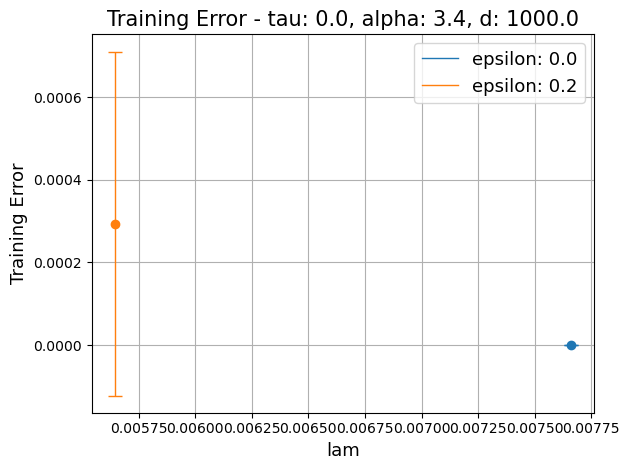

In [297]:
# plot the erm training error
create_plot(df, "Training Error", "training_error_state_evolution","training_error_erm",log_y=False)

In [298]:
# # Let's add a new column to the dataframe for the training error in terms of erm overlaps, except for sigma

# df.apply()

# training_error_overlaps: float = training_error_logistic(m,Q,sigma,A,N,rho,n/d,tau,epsilon, lam)

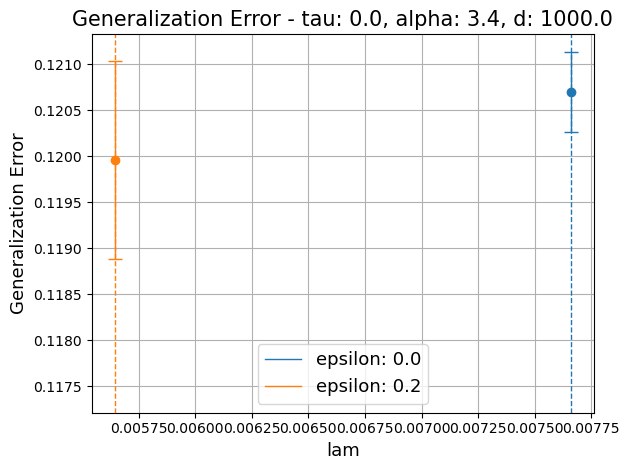

In [299]:
create_plot(df, "Generalization Error", "generalization_error_state_evolution", "generalization_error_erm_erm", log_y=False)

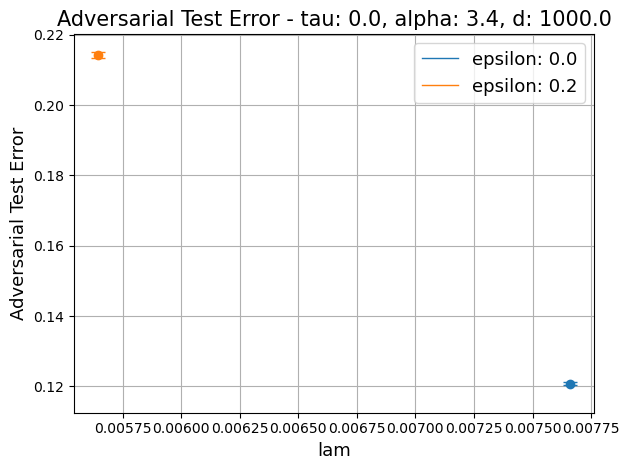

In [301]:
create_plot(df, "Adversarial Test Error", "adversarial_generalization_error_state_evolution", "adversarial_generalization_error_erm_erm",log_y=False)

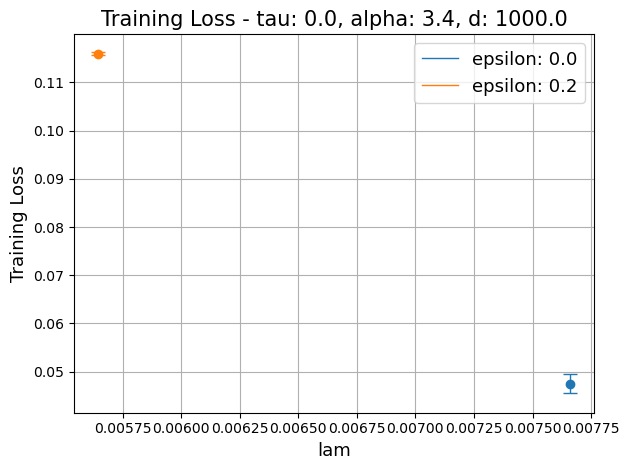

In [302]:
create_plot(df, "Training Loss", "training_loss_state_evolution", "training_loss_erm", log_y=False)

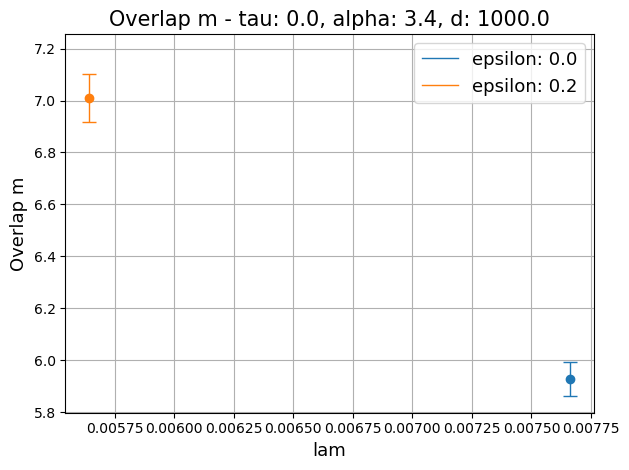

In [303]:
create_plot(df, "Overlap m", "m_state_evolution","m_erm", log_y=False)

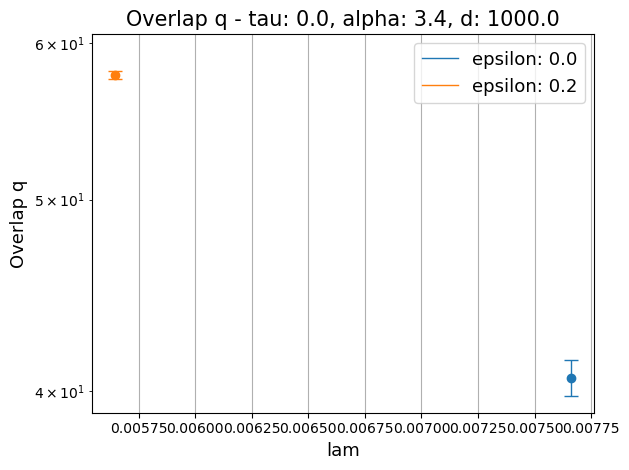

In [304]:
create_plot(df, "Overlap q", "q_state_evolution","Q_erm", log_y=True)

In [305]:
# Plot the Q_self_state_evolution overlap vs Q_erm
# create_plot(df, "Overlap Q", "Q_self_state_evolution","Q_erm", log_y=False)

In [306]:
# Plot the A_self overlap
# create_plot(df, "A_self", "A_self_state_evolution","A_erm", log_y=False)

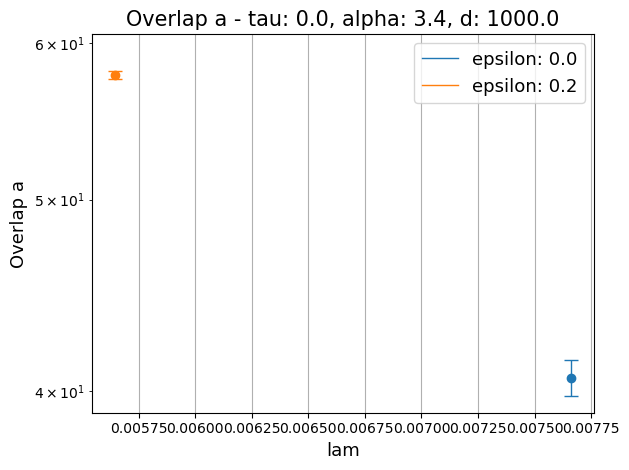

In [307]:
# Plot the a overlap
create_plot(df, "Overlap a", "A_state_evolution","A_erm", log_y=True)

In [308]:
# Plot the N_self overlap
# create_plot(df, "N_self", "N_self_state_evolution","N_erm", log_y=False)

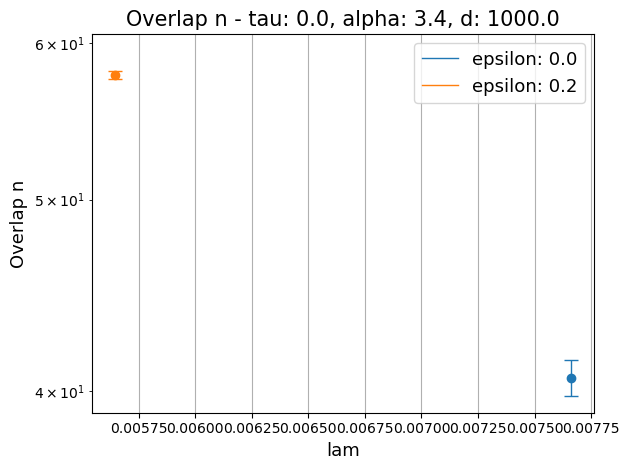

In [309]:
# Plot the n overlap
create_plot(df, "Overlap n", "N_state_evolution","N_erm", log_y=True)

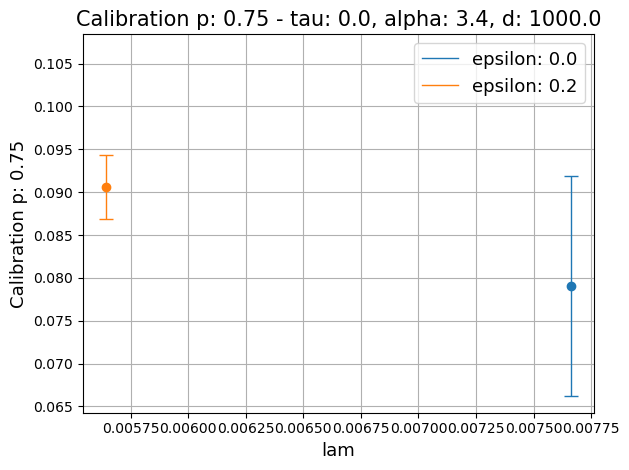

In [310]:
# subset df to keep only where p = 0.5
p = 0.75
dfp = df[df.index.get_level_values("p_calibration") == p]
# remove epsilon = 1
# dfp = dfp[dfp.index.get_level_values("epsilon") != 1]

create_plot(dfp, f"Calibration p: {p}", "calibration_state_evolution","erm_calibration_erm",log_y=False)
# erm_calibration_erm	analytical_calibration_erm	calibration_state_evolution

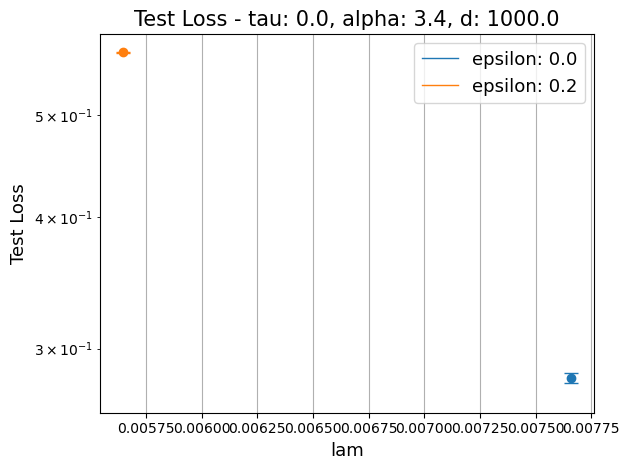

In [311]:
# plot test loss erm
create_plot(df, "Test Loss", "test_loss_state_evolution","test_loss_erm",log_y=True)

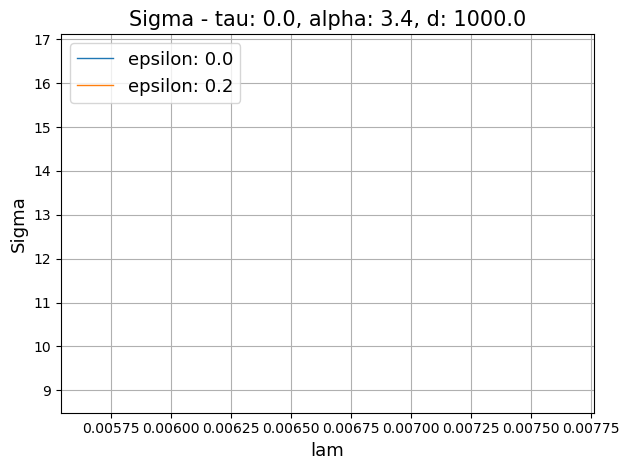

In [312]:
# Plot sigma for the state evolution
create_plot(df, "Sigma", "sigma_state_evolution", None, log_y=False)

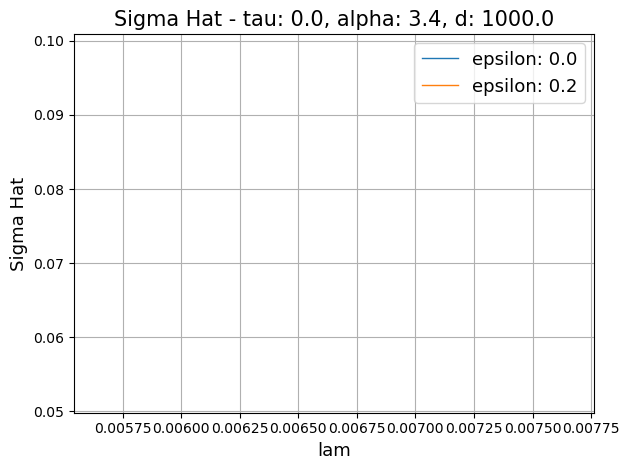

In [313]:
# Plot sigma_hat for the state evolution
create_plot(df, "Sigma Hat", "sigma_hat_state_evolution", None, log_y=False)

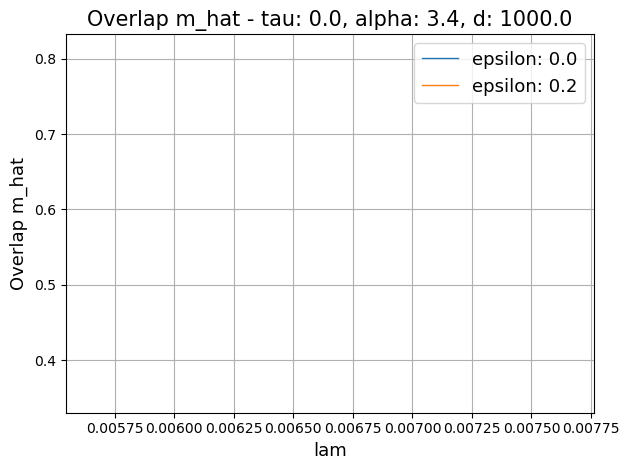

In [314]:
# Plot m_hat for the state evolution
create_plot(df, "Overlap m_hat", "m_hat_state_evolution", None, log_y=False)

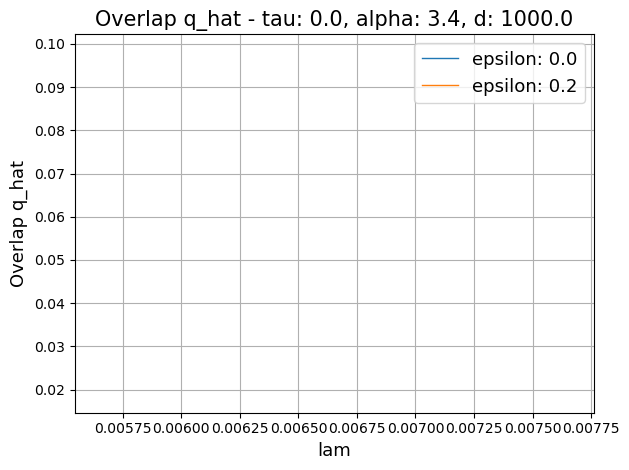

In [315]:
# Plot q_hat for the state_evolution
create_plot(df, "Overlap q_hat", "q_hat_state_evolution", None, log_y=False)

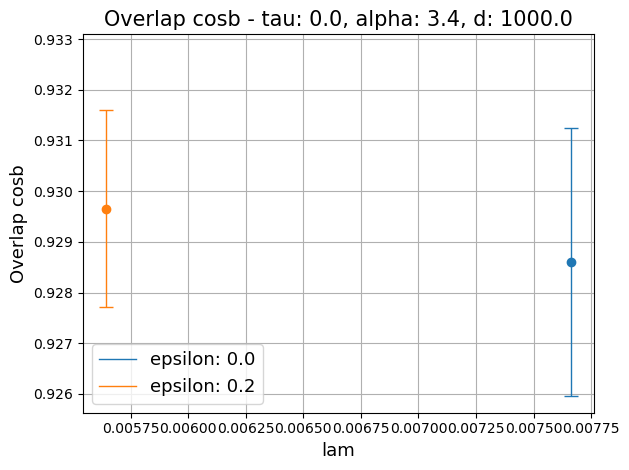

In [316]:
create_plot(df, "Overlap cosb", "cosb_state_evolution","cosb_erm",log_y=False)

## Log-Log Plots of overlaps in State_evolution

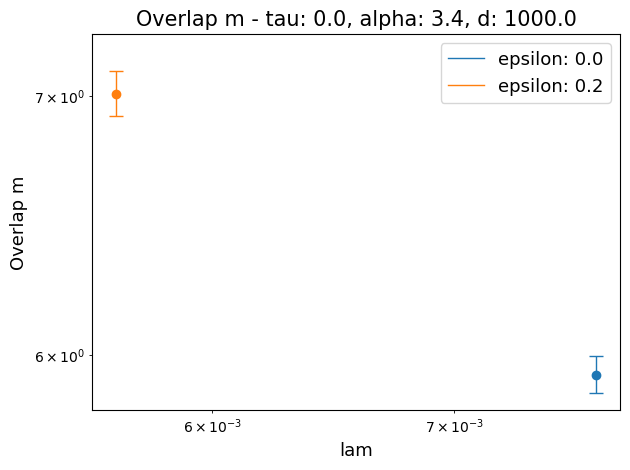

In [317]:
# create a log-log plot of the overlap m
create_plot(df, "Overlap m", "m_state_evolution","m_erm", log_x=True, log_y=True)

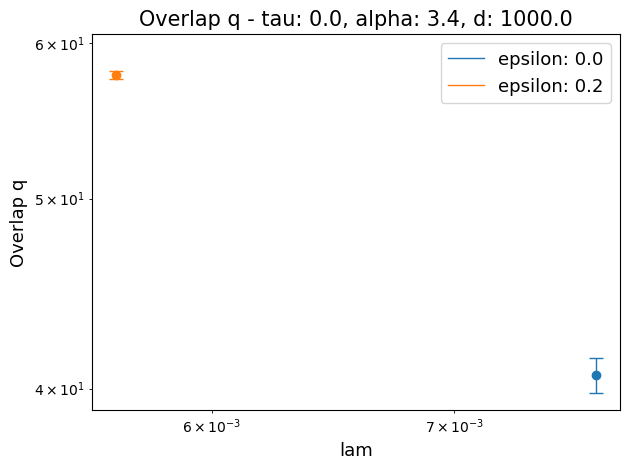

In [318]:
# create a log-log plot of the overlap q
create_plot(df, "Overlap q", "q_state_evolution","Q_erm", log_x=True, log_y=True)

In [319]:
# create a log-log plot of the overlap sigma
# create_plot(df, "Overlap sigma", "sigma_state_evolution",None, log_x=True, log_y=True)

In [320]:
# create a log-log plot of the overlap sigma_hat
# create_plot(df, "Overlap sigma_hat", "sigma_hat_state_evolution",None, log_x=True, log_y=True)

In [321]:
# create a log-log plot of the overlap q_hat
# create_plot(df, "Overlap q_hat", "q_hat_state_evolution",None, log_x=True, log_y=True)

In [322]:
# create a log-log plot of the overlap m_hat
# create_plot(df, "Overlap m_hat", "m_hat_state_evolution",None, log_x=True, log_y=True)